In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (precision_recall_curve, auc,
                             accuracy_score, classification_report)
from statannotations.Annotator import Annotator
from biom import load_table
from matplotlib_venn import venn2

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load data

In [2]:
#load rpca results
nPCs = 4
ord_18S = OrdinationResults.read('../results/joint-rpca/Ordinations/18S_ord_{}PCs.txt'.format(nPCs))
ord_mag = OrdinationResults.read('../results/joint-rpca/Ordinations/mag_ord_{}PCs.txt'.format(nPCs))
ord_gene = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_ord_{}PCs.txt'.format(nPCs))
ord_gene_module = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_module_ord_{}PCs.txt'.format(nPCs))
ord_metabolite = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(nPCs))
ord_joint_adjusted = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs_top_filtered.txt'.format(nPCs))
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [3]:
for ord, name in zip([ord_18S, ord_mag, ord_gene, ord_gene_module, 
                      ord_metabolite, ord_joint, ord_joint_adjusted],
                     ['18S RPCA', 'MAG RPCA', 'Gene RPCA', 'Gene Module RPCA', 
                      'Metabolite RPCA', 'Joint-RPCA', 'Joint-RPCA Adjuste']):
    print("{} with {} features".format(name, ord.features.shape[0]))
    print("Eigvals: ", ord.eigvals.values)
    print("Prop explained: ", ord.proportion_explained.values)
    print()

18S RPCA with 5431 features
Eigvals:  [93.09064035 54.63506677 43.74805468 41.32123107]
Prop explained:  [0.56742778 0.19545263 0.12531875 0.11180084]

MAG RPCA with 257 features
Eigvals:  [324.33673124  80.2481485   70.88832521  60.15480628]
Prop explained:  [0.87459435 0.05354075 0.04177956 0.03008535]

Gene RPCA with 2457 features
Eigvals:  [76.17102001 14.76430068  9.69162976  8.33676539]
Prop explained:  [0.93831685 0.03525297 0.0151902  0.01123997]

Gene Module RPCA with 377 features
Eigvals:  [173.74807179   5.22776893   4.62675072   3.5496359 ]
Prop explained:  [9.97972335e-01 9.03464893e-04 7.07669889e-04 4.16529851e-04]

Metabolite RPCA with 2333 features
Eigvals:  [101.66422711  14.32803815  13.92976621   8.68185405]
Prop explained:  [0.95608774 0.01899043 0.01794936 0.00697247]

Joint-RPCA with 10855 features
Eigvals:  [176.81114729 122.43351045 110.30745766  96.63676112]
Prop explained:  [0.46137623 0.22122619 0.17957492 0.13782267]

Joint-RPCA Adjuste with 8776 features
E

In [4]:
ord_metabolomics = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolomics_ord_{}PCs.txt'.format(nPCs))
print("Metabolomics RPCA with {} features".format(ord_metabolomics.features.shape[0]))
print("Eigvals: ", ord_metabolomics.eigvals.values)
print("Prop explained: ", ord_metabolomics.proportion_explained.values)

Metabolomics RPCA with 2333 features
Eigvals:  [101.66422711  14.32803815  13.92976621   8.68185405]
Prop explained:  [0.95608774 0.01899043 0.01794936 0.00697247]


## Define functions

In [5]:
def rf_acc(ord_tables, ord_ids, shared_mt, cat_of_interest,
           ordination=True, n_folds=10, n_estimators=100, 
           random_state=42, optimize=False, param_grid=None, 
           bootstrap=True, **kwargs):

    acc_ord = {}
    apr_ord = {}
    prop_ord = {}
    
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        
        if ordination:
            X = ord.samples.copy()
        else: 
            X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        acc_fold = {}
        apr_fold = {}
        properties_fold = {}

        for fold in ['traintest_{}'.format(i) for i in range(n_folds)]:
            
            #split data into pre-defined train and test sets
            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if optimize:
                print(f'Optimizing hyperparameters for {omic}, {fold}...')
                #initialize random forest
                rf = RandomForestClassifier(random_state=random_state)
                #hyperparameter optimization
                grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                           cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
                grid_search.fit(X_train.values, y_train)
                
                print(f'Best parameters found: {grid_search.best_params_}')
                print(f'Best cross-validation accuracy: {grid_search.best_score_}')

                #save best parameters
                best_params = grid_search.best_params_.copy()
                best_params['best_score'] = grid_search.best_score_
                #get best model
                best_rf = grid_search.best_estimator_
            else:
                #initialize random forest with user-defined parameters
                rf = RandomForestClassifier(n_estimators=n_estimators, 
                                            bootstrap=bootstrap,
                                            random_state=random_state, 
                                            **kwargs)
                rf.fit(X_train.values, y_train)
                best_params = 'None'
                best_rf = rf
            
            #save classes or categories
            rf_classes = list(best_rf.classes_)
            #save feature importances and in-bag samples
            feature_importances = best_rf.feature_importances_
            in_bag_samples = best_rf.estimators_samples_
            properties_fold[fold] = (feature_importances, in_bag_samples)

            #predict on test set
            y_pred = best_rf.predict(X_test)
            y_proba = best_rf.predict_proba(X_test)
            #get accuracy and classification report
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            #save results for each fold
            acc_fold[fold] = (accuracy, report, best_params)

            #binary apr
            apr_cat = {}
            for cat in y.unique():
                cat_index = rf_classes.index(cat)
                precision, recall, _ = precision_recall_curve(y_test, y_proba[:, cat_index],
                                                                pos_label=cat)
                apr = auc(x=recall, y=precision)
                apr_cat[cat] = (apr, precision, recall, best_params)
            apr_fold[fold] = apr_cat
        
        #save results for each omic
        acc_ord[omic] = acc_fold
        apr_ord[omic] = apr_fold
        prop_ord[omic] = properties_fold


    #initialize dataframes to store results
    acc_metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                           'Report', 'Optimization'])
    apr_metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Category',  
                                           'APR', 'Precision', 'Recall',
                                           'Optimization'])
    properties_df = pd.DataFrame(columns=['Omic', 'Fold', 'Feature_importances', 
                                          'In_bag_samples'])
    
    #create df with metrics
    for omic, acc_fold in acc_ord.items():
        for fold, metrics in acc_fold.items():
            acc_metrics_df = acc_metrics_df._append({'Omic': omic, 'Fold': fold, 
                                                     'Accuracy': metrics[0], 
                                                     'Report': metrics[1], 
                                                     'Optimization': metrics[2]}, 
                                                     ignore_index=True)
    for omic, apr_fold in apr_ord.items():
        for fold, metrics in apr_fold.items():
            for cat, apr in metrics.items():
                apr_metrics_df = apr_metrics_df._append({'Omic': omic, 'Fold': fold, 
                                                         'Category': cat, 'APR': apr[0],
                                                         'Precision': apr[1], 'Recall': apr[2],
                                                         'Optimization': apr[3]}, 
                                                         ignore_index=True)
    #save feature importances and in-bag samples
    for omic, prop_fold in prop_ord.items():
        for fold, prop in prop_fold.items():
            properties_df = properties_df._append({'Omic': omic, 'Fold': fold, 
                                                   'Feature_importances': prop[0], 
                                                   'In_bag_samples': prop[1]}, 
                                                   ignore_index=True)
            
    if bootstrap == False:
        #drop columns with in-bag samples
        properties_df.drop('In_bag_samples', axis=1, inplace=True)
    
    return acc_metrics_df, apr_metrics_df, properties_df

In [6]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

## Ordination-based classification

### RF default params

In [7]:
#FACILITY
(acc_ord_facility,
 apr_ord_facility,
 rf_prop_facility) = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, 
                                        ord_joint, ord_joint_adjusted],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", 
                                     "Joint_RPCA", "Joint_RPCA_Adjusted"], 
                            shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                            random_state=42, bootstrap=True, optimize=False, param_grid=None)

display(acc_ord_facility.head())
display(apr_ord_facility.head())
display(rf_prop_facility.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.872340,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.797872,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.765957,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.861702,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.808511,precision recall f1-score ...,None


,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,STAFS,0.936702,"[0.32978723404255317, 0.41333333333333333, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.967...",None
1,18S_RPCA,traintest_0,FIRS,0.915484,"[0.1595744680851064, 0.30612244897959184, 0.33...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, ...",None
2,18S_RPCA,traintest_0,ARF,0.964445,"[0.5106382978723404, 0.5647058823529412, 0.6, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
3,18S_RPCA,traintest_1,STAFS,0.893285,"[0.32978723404255317, 0.41333333333333333, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.967...",None
4,18S_RPCA,traintest_1,FIRS,0.796363,"[0.1595744680851064, 0.24528301886792453, 0.28...","[1.0, 0.8666666666666667, 0.8666666666666667, ...",None


,Omic,Fold,Feature_importances,In_bag_samples
0,18S_RPCA,traintest_0,"[0.3162576656933816, 0.14468544049340884, 0.28...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
1,18S_RPCA,traintest_1,"[0.2973026334885167, 0.1489971856445594, 0.299...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
2,18S_RPCA,traintest_2,"[0.3240234921058452, 0.12990580138552107, 0.29...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
3,18S_RPCA,traintest_3,"[0.2954725962033012, 0.14705473102794556, 0.31...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
4,18S_RPCA,traintest_4,"[0.29792864453500667, 0.13893517421897816, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."


In [ ]:
# save results
#acc_ord_facility.to_csv('../results/joint-rpca/RF/rf_acc_facility_4PCs.csv', index=False)
#apr_ord_facility.to_csv('../results/joint-rpca/RF/rf_apr_facility_4PCs.csv', index=False)
#rf_prop_facility.to_csv('../results/joint-rpca/RF/rf_prop_facility_4PCs.csv', index=False)

In [8]:
#STAGE OF DECOPMPOSITION (ADD 0C)
(acc_ord_stage,
 apr_ord_stage,
 rf_prop_stage) = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                     ord_gene_module, ord_metabolite, 
                                     ord_joint, ord_joint_adjusted],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                  "Gene_Module_RPCA", "Metabolite_RPCA", 
                                  "Joint_RPCA", "Joint_RPCA_Adjusted"],
                         shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                         random_state=42, bootstrap=True, optimize=False, param_grid=None)

display(acc_ord_stage.head())
display(apr_ord_stage.head())
display(rf_prop_stage.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.510638,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.531915,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.542553,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.457447,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.542553,precision recall f1-score ...,None


,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,advanced,0.799006,"[0.46808510638297873, 0.4731182795698925, 0.48...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97727272...",None
1,18S_RPCA,traintest_0,active,0.532589,"[0.3723404255319149, 0.3804347826086957, 0.384...","[1.0, 1.0, 1.0, 1.0, 0.9714285714285714, 0.971...",None
2,18S_RPCA,traintest_0,early,0.140689,"[0.11702127659574468, 0.14285714285714285, 0.1...","[1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 0.727...",None
3,18S_RPCA,traintest_0,initial,0.037479,"[0.0425531914893617, 0.046875, 0.04, 0.0476190...","[1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0...",None
4,18S_RPCA,traintest_1,advanced,0.671534,"[0.3829787234042553, 0.391304347826087, 0.4, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97222222...",None


,Omic,Fold,Feature_importances,In_bag_samples
0,18S_RPCA,traintest_0,"[0.2566790096048213, 0.28365901147124606, 0.21...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
1,18S_RPCA,traintest_1,"[0.25751210499125554, 0.27804069040494445, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
2,18S_RPCA,traintest_2,"[0.24708247936437175, 0.29992775704768043, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
3,18S_RPCA,traintest_3,"[0.25696772370167503, 0.276514518505155, 0.221...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
4,18S_RPCA,traintest_4,"[0.24400742833482497, 0.28707555710099925, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."


In [ ]:
# save results
#acc_ord_stage.to_csv('../results/joint-rpca/RF/rf_acc_stage_4PCs.csv', index=False)
#apr_ord_stage.to_csv('../results/joint-rpca/RF/rf_apr_stage_4PCs.csv', index=False)
#rf_prop_stage.to_csv('../results/joint-rpca/RF/rf_prop_stage_4PCs.csv', index=False)

In [9]:
#SEASON
(acc_ord_season,
 apr_ord_season,
 rf_prop_season) = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, 
                                      ord_joint, ord_joint_adjusted],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                   "Gene_Module_RPCA", "Metabolite_RPCA", 
                                   "Joint_RPCA", "Joint_RPCA_Adjusted"],
                          shared_mt=metadata, cat_of_interest='season', ordination=True, 
                          random_state=42, bootstrap=True, optimize=False, param_grid=None)

display(acc_ord_season.head())
display(apr_ord_season.head())
display(rf_prop_season.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.861702,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.904255,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.893617,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.819149,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.925532,precision recall f1-score ...,None


,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,spring,0.986203,"[0.2978723404255319, 0.4666666666666667, 0.518...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
1,18S_RPCA,traintest_0,summer,0.902099,"[0.32978723404255317, 0.39473684210526316, 0.4...","[1.0, 0.967741935483871, 0.967741935483871, 0....",None
2,18S_RPCA,traintest_0,fall,0.856577,"[0.20212765957446807, 0.34545454545454546, 0.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
3,18S_RPCA,traintest_0,winter,0.931567,"[0.1702127659574468, 0.2962962962962963, 0.333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
4,18S_RPCA,traintest_1,spring,0.957338,"[0.26595744680851063, 0.4166666666666667, 0.46...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.96, 0.96, 0....",None


,Omic,Fold,Feature_importances,In_bag_samples
0,18S_RPCA,traintest_0,"[0.23662708329869966, 0.3121149472664977, 0.24...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
1,18S_RPCA,traintest_1,"[0.2511854011368676, 0.31680708691660875, 0.24...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
2,18S_RPCA,traintest_2,"[0.2267521346171731, 0.31270138347902393, 0.24...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
3,18S_RPCA,traintest_3,"[0.23212977320030392, 0.31320588730199794, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."
4,18S_RPCA,traintest_4,"[0.23302516218101205, 0.31792845539061537, 0.2...","[[41, 130, 231, 92, 199, 120, 28, 233, 84, 6, ..."


In [ ]:
# save results
#acc_ord_season.to_csv('../results/joint-rpca/RF/rf_acc_season_4PCs.csv', index=False)
#apr_ord_season.to_csv('../results/joint-rpca/RF/rf_apr_season_4PCs.csv', index=False)
#rf_prop_season.to_csv('../results/joint-rpca/RF/rf_prop_season_4PCs.csv', index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Joint_RPCA_Adjusted vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:6.584e-02 Stat=7.000e+00
Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.639e-02 Stat=6.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Joint_RPCA_Adjusted vs. Joint_RPCA: Wilcoxon test (paired sam

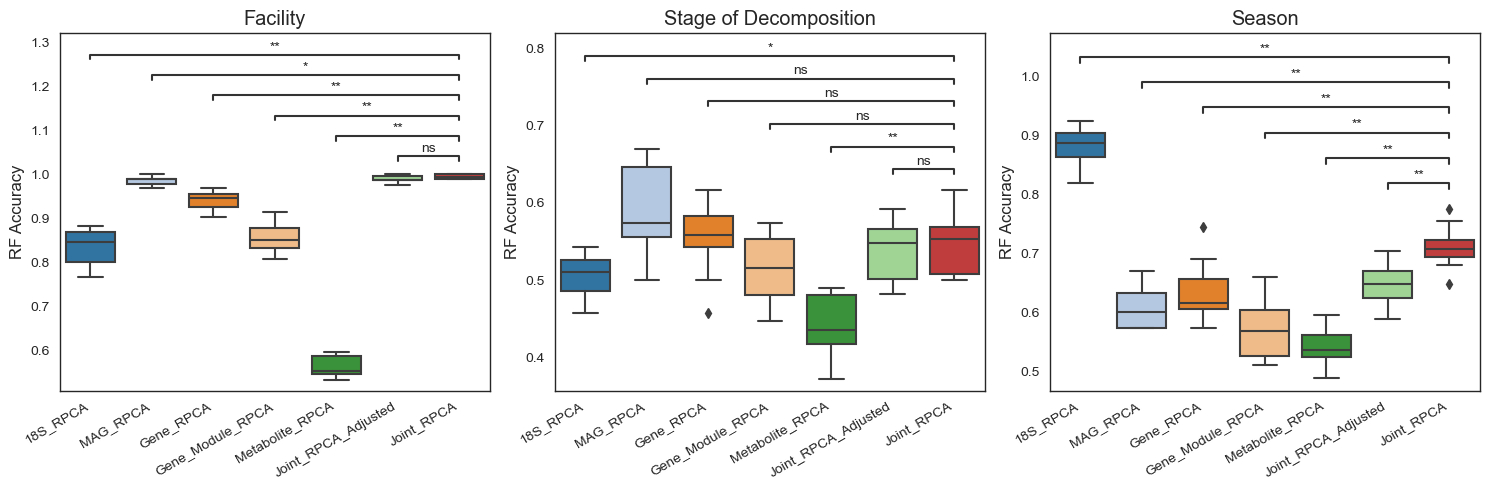

In [11]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 
         'Joint_RPCA_Adjusted', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility, acc_ord_stage, acc_ord_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Binary APRs

In [ ]:
# #read results
# acc_ord_facility = pd.read_csv('../results/joint-rpca/RF/rf_acc_facility_4PCs.csv')
# apr_ord_stage = pd.read_csv('../results/joint-rpca/RF/rf_apr_stage_4PCs.csv')
# apr_ord_season = pd.read_csv('../results/joint-rpca/RF/rf_apr_season_4PCs.csv')

In [12]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA",
              "Joint_RPCA_Adjusted"]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'hue_order':rpca_types+['Joint_RPCA']}

Facility
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

STAFS_Joint_RPCA_Adjusted vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.472e-02 U_stat=2.200e+01
FIRS_Joint_RPCA_Adjusted vs. FIRS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.675e-01 U_stat=4.000e+01
ARF_Joint_RPCA_Adjusted vs. ARF_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:5.033e-02 U_stat=2.850e+01
STAFS_Metabolite_RPCA vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
FIRS_Metabolite_RPCA vs. FIRS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:6.386e-05 U_stat=0.000e+00
ARF_Metabolite_RPCA vs. ARF_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
STAFS_Gene_Module_RPCA vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.0

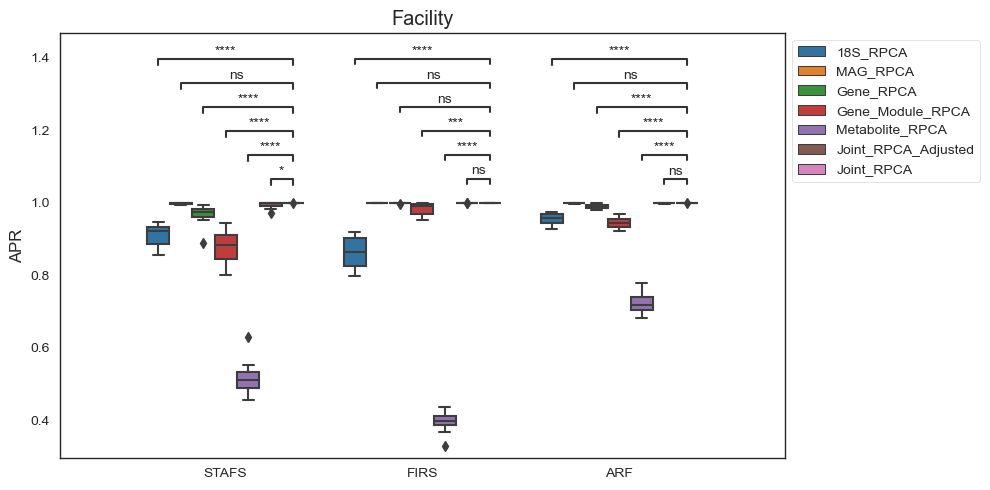

Stage of Decomposition
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

advanced_Joint_RPCA_Adjusted vs. advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
active_Joint_RPCA_Adjusted vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:4.922e-01 Stat=2.000e+01
early_Joint_RPCA_Adjusted vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.900e+01
initial_Joint_RPCA_Adjusted vs. initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
advanced_Metabolite_RPCA vs. advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
active_Metabolite_RPCA vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
early_Metabolite_RPCA vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00


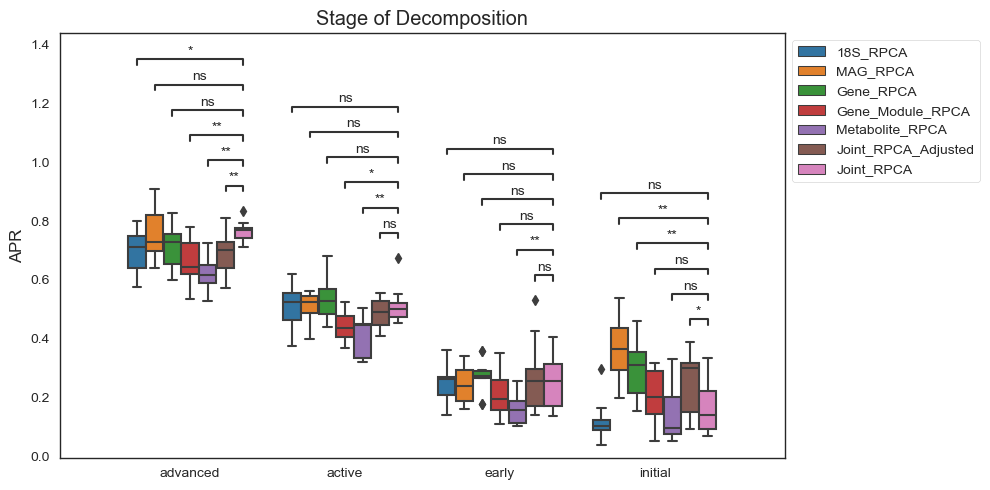

Season
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

spring_Joint_RPCA_Adjusted vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Joint_RPCA_Adjusted vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
fall_Joint_RPCA_Adjusted vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Joint_RPCA_Adjusted vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01
spring_Metabolite_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Metabolite_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Metabolite_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Metabolite_RPCA vs. win

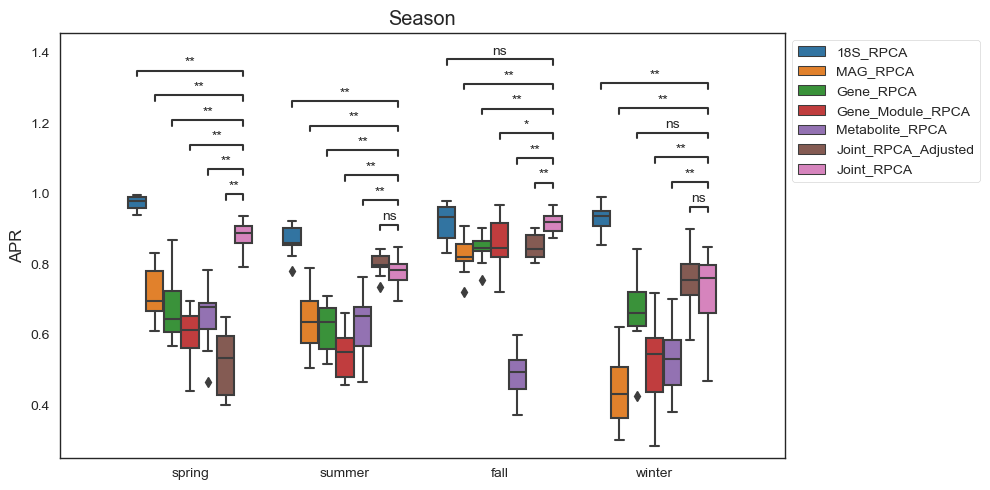

In [14]:
#seaborn boxplot of individual APRs with stat test
for df, title in zip([apr_ord_facility, apr_ord_stage, apr_ord_season],
                     ['Facility', 'Stage of Decomposition', 'Season']):
    
    print(title)
    plotting_params['data'] = df
    groups = df['Category'].unique()
    stat_pairs = [[(group, rpca), (group, "Joint_RPCA")] for
                    group in groups for rpca in rpca_types]

    plt.figure(figsize=(10, 5))
    ax_ = plt.gca()
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    if title=='Facility':
        test_name = "Mann-Whitney"
    else:
        test_name = "Wilcoxon"
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test=test_name).apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #x axis rotation
    #ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
    ax_.set_xlabel('')
    ax_.set_ylabel('APR')
    ax_.set_title(title)
    #plot legend outside of box
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

advanced_Joint_RPCA vs. advanced_MAG_RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.500e+01
advanced_Joint_RPCA vs. advanced_Gene_RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
advanced_Joint_RPCA vs. advanced_18S_RPCA: Wilcoxon test (paired samples), P_val:2.734e-02 Stat=6.000e+00
advanced_Joint_RPCA vs. advanced_Joint_RPCA_Adjusted: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
advanced_Joint_RPCA vs. advanced_Gene_Module_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
advanced_Joint_RPCA vs. advanced_Metabolite_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00


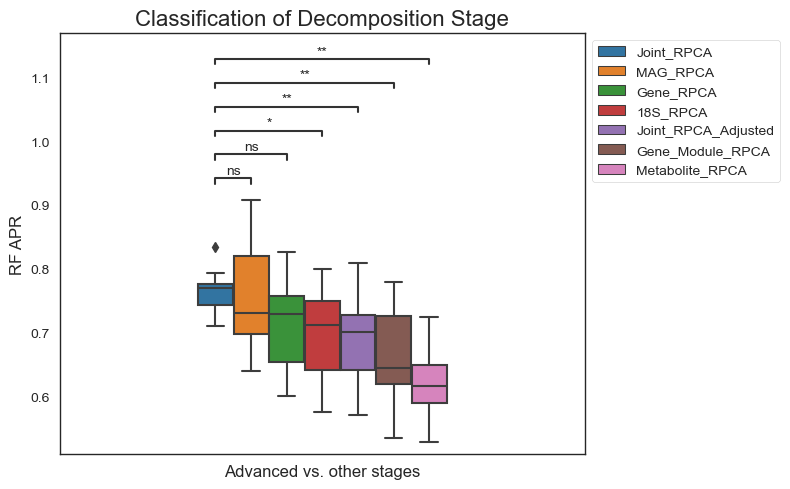

In [15]:
#focus on active vs all task
df = apr_ord_stage[apr_ord_stage.Category=="advanced"]
#get order based on median APR
order = df.groupby('Omic')['APR'].median().sort_values(ascending=False).index

plotting_params['data'] = df
plotting_params['hue_order'] = order
groups = df['Category'].unique()
stat_pairs = [[(group, rpca), (group, "Joint_RPCA")] for
                group in groups for rpca in rpca_types]

plt.figure(figsize=(8, 5))
ax_ = plt.gca()
p = sns.boxplot(ax=ax_, **plotting_params)
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(['Advanced vs. other stages'], fontsize=12)
ax_.set_xlabel('')
ax_.set_ylabel('RF APR', fontsize=12)
ax_.set_title('Classification of Decomposition Stage', fontsize=16)
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [16]:
#calculate average AUC_APR for each fold
apr_avg_facility = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])
apr_avg_stage = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])
apr_avg_season = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])
n_omic = len(rpca_types)+1

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_ord_facility[apr_ord_facility['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_fac = pd.DataFrame(zip([fold_]*n_omic, avg1.index, avg1['APR']),
                               columns=['Fold', 'Omic', 'APR'])
    apr_avg_facility = pd.concat([apr_avg_facility, apr_avg_fac])

    avg2 = apr_ord_stage[apr_ord_stage['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*n_omic, avg2.index, avg2['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_stage = pd.concat([apr_avg_stage, apr_avg_st])

    avg3 = apr_ord_season[apr_ord_season['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_se = pd.DataFrame(zip([fold_]*n_omic, avg3.index, avg3['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_season = pd.concat([apr_avg_season, apr_avg_se])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Joint_RPCA_Adjusted vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.252e-02 Stat=2.000e+00
Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.159e-01 Stat=3.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Joint_RPCA_Adjusted vs. Joint_RPCA: Wilcoxon test (paired sam

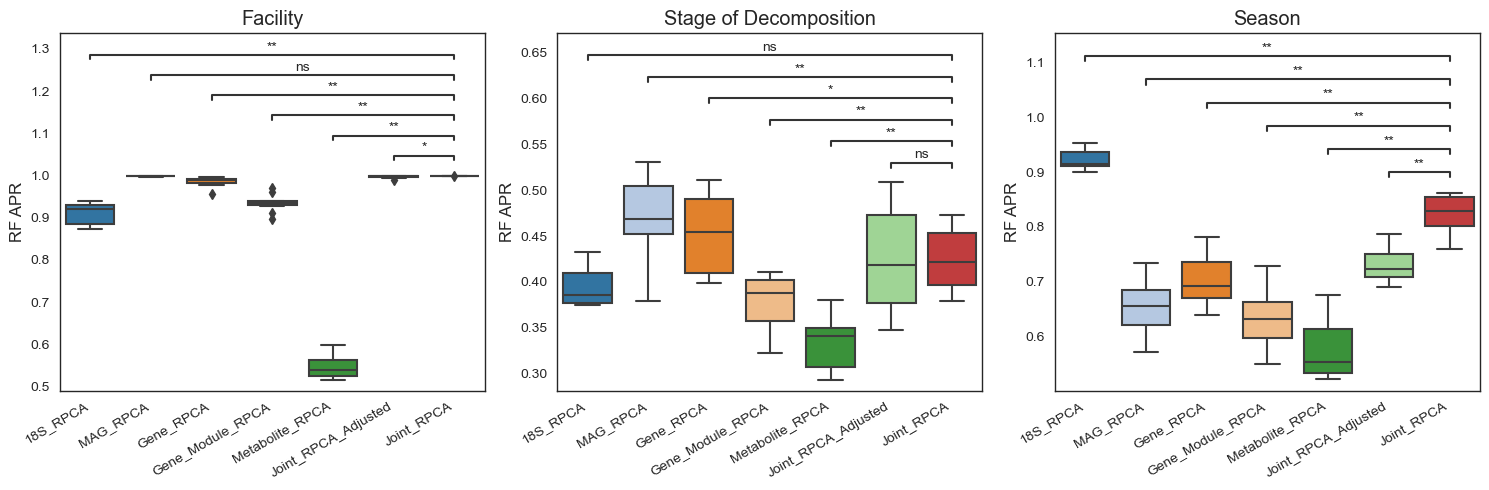

In [17]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 
         'Joint_RPCA_Adjusted', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'APR', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [apr_avg_facility, apr_avg_stage, apr_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('RF APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Binned stages of decomposition

In [18]:
#join early/initial together and active/advanced together
metadata_stage_binned = metadata.copy()
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'early', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'initial', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'active', 'add_0c_group'] = 'active/advanced'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'advanced', 'add_0c_group'] = 'active/advanced'

In [19]:
#STAGE OF DECOMPOSITION (BINNED)
(acc_ord_stage_binned,
 apr_ord_stage_binned,
 rf_prop_stage_binned) = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                            ord_gene_module, ord_metabolite, 
                                            ord_joint_adjusted, ord_joint],
                                ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                         "Gene_Module_RPCA", "Metabolite_RPCA", 
                                         "Joint_RPCA_Adjusted", "Joint_RPCA"],
                                shared_mt=metadata_stage_binned, cat_of_interest='add_0c_group',
                                random_state=42)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active/advanced_Joint_RPCA_Adjusted vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
early/initial_Joint_RPCA_Adjusted vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.500e+01
active/advanced_Metabolite_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
early/initial_Metabolite_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
active/advanced_Gene_Module_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
early/initial_Gene_Module_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.219e-01 Stat=2.600e+01
active/advanced_Gene_RPCA vs. active/advanced_Jo

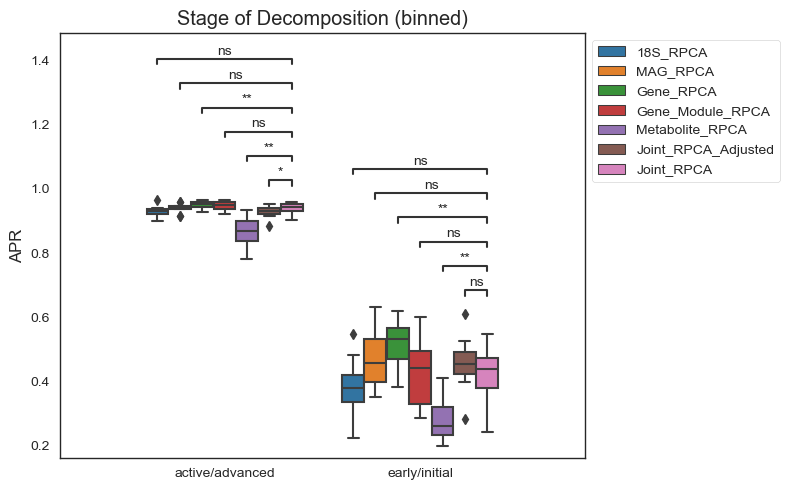

In [20]:
stages = apr_ord_stage_binned.Category.unique()
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA",
              "Joint_RPCA_Adjusted"]
stat_pairs = [[(stg, rpca), (stg, "Joint_RPCA")] for
                stg in stages for rpca in rpca_types]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'data':apr_ord_stage_binned}

#seaborn boxplot of individual APRs with stat test
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
#ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('APR')
ax_.set_title('Stage of Decomposition (binned)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active/advanced_Joint_RPCA_Adjusted vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.219e-01 Stat=2.600e+01
active/advanced_Metabolite_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
active/advanced_Gene_Module_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
active/advanced_Gene_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
active/advanced_MAG_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=2.700e+01
active/advanced_18S_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01


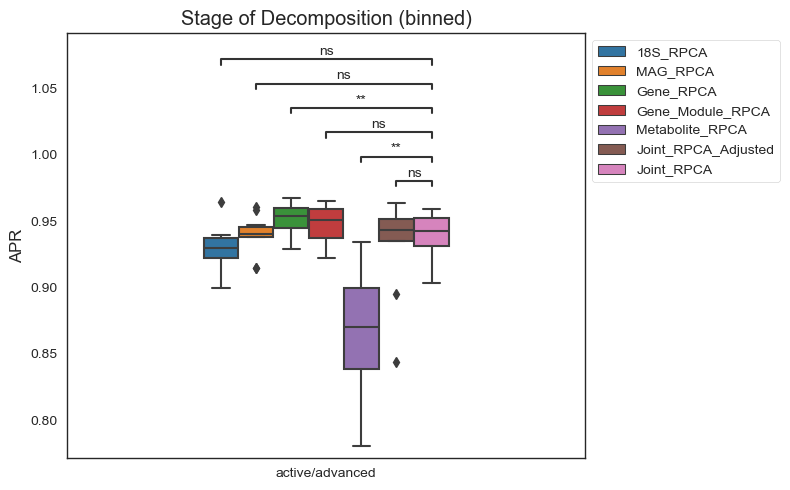

In [36]:
stages = ["active/advanced"]
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA",
              "Joint_RPCA_Adjusted"]
stat_pairs = [[(stg, rpca), (stg, "Joint_RPCA")] for
                stg in stages for rpca in rpca_types]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'data':apr_ord_stage_binned[apr_ord_stage_binned.Category != 'early/initial']}

#seaborn boxplot of individual APRs with stat test
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
#ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('APR')
ax_.set_title('Stage of Decomposition (binned)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
#calculate average AUC_APR for each fold
apr_avg_stage_binned = pd.DataFrame(columns=['Fold', 'Omic', 'APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:

    avg = ord_stage_binned[ord_stage_binned['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg.index, avg['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_stage_binned = pd.concat([apr_avg_stage_binned, apr_avg_st])

In [ ]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]

plotting_params = {'x':'Omic', 'y':'APR', 
                   'order':order, 'palette':'tab20',
                   'data':apr_avg_stage_binned}

fig = plt.figure(figsize=(5, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
ax_.set_xlabel('')
ax_.set_ylabel('RF APR')
ax_.set_title('Early/Initial vs. Active/Advanced')

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Hyper-parameter optimization

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
#FACILITY
acc_ord_facility_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                          ord_gene_module, ord_metabolite, ord_joint],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                       "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                              shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ord_facility_opt.to_csv('../results/joint-rpca/rf_acc_facility_opt.csv', index=False)
display(acc_ord_facility_opt.head())

In [ ]:
#STAGE OF DECOMPOSITION (ADD 0C)
acc_ord_stage_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ord_stage_opt.to_csv('../results/joint-rpca/rf_acc_stage_opt.csv', index=False)
display(acc_ord_stage_opt.head())

In [ ]:
for fold in ['traintest_{}'.format(i) for i in range(10)]:
    for group in metadata.add_0c_group.unique():
        print(fold, group)
        print(metadata[metadata.add_0c_group == group][fold].value_counts())
    print()

In [ ]:
#SEASON
acc_ord_season_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='season', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ord_season_opt.to_csv('../results/joint-rpca/rf_acc_season_opt.csv', index=False)
display(acc_ord_season_opt.head())

In [ ]:
#plot results and run statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab10'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility_opt, acc_ord_stage_opt, acc_ord_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Bar plots with detailed F1s

In [ ]:
# load the results
acc_ord_season = pd.read_csv('../results/joint-rpca/RF/rf_acc_season_4PCS.csv')
#acc_ord_season = pd.read_csv('../results/joint-rpca/KNN/knn_acc_ord_season_4PCs.tsv', sep='\t', index_col=0)
# display(acc_ord_season_opt.head())
# print(acc_ord_season_opt.shape)

In [ ]:
omic_f1_lst = []
groups = ['fall', 'spring', 'summer', 'winter']
for omic in acc_ord_season.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = acc_ord_season[(acc_ord_season.Omic == omic) & 
                                     (acc_ord_season.Fold == fold)].Report.values[0]
        #get each season's F1-score
        season_f1_lst = []
        for season, i in zip(groups, range(2, 6)):
            season_report = fold_report.split('\n')[i].split(' ')
            season_result = [x for x in season_report if len(x)>0][1:]
            season_f1 = [float(x) for x in season_result][2]
            season_f1_lst.append(season_f1)
        fold_f1_lst.extend(season_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [ ]:
#create new dataframe with f1 results
n_omics = len(acc_ord_season.Omic.unique())
n_groups = len(groups)
omic_lst = [[omic] * 10 * n_groups for omic in acc_ord_season.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * n_groups for i in range(10)] * n_omics
fold = np.concatenate(fold)
season = ['fall', 'spring', 'summer', 'winter'] * acc_ord_season.shape[0]

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 'Season': season, 'F1-score': omic_f1_lst})
f1_df.head()

In [ ]:
seasons = ["fall", "spring", "summer", "winter"]
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(season, rpca), (season, "Joint_RPCA")] for
               season in seasons for rpca in rpca_types]

plotting_params = {'x':'Season', 'y':'F1-score', 
                   'palette':'tab10',
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('Season (Detailed)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## Feature-based classification

In [7]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [8]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


### Default parameters

Perform classification tasks with features from each PC

In [9]:
#common parameters
quantile = 0.90
pc_list = ['PC1', 'PC2', 'PC3', 'PC4']

rpca_top_fts_all = {}
rpca_bot_fts_all = {}
joint_top_fts_all = {}
joint_bot_fts_all = {}

for pc_to_use in pc_list:
    print("Currently using %s features" % pc_to_use)
    
    #find top/bottom features from individual RPCA results
    rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
                'gene_module': ord_gene_module, 'metabolite': ord_metabolite}
    rpca_top_fts = {}
    rpca_bottom_fts = {}
    rpca_traj = {}

    for omic in tables.keys():
        ord_ = rpca_ord[omic].features.copy()
        table_ = tables[omic]
        _, _, beta_l, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                             quantile=quantile, pseudocount=0)
        rpca_top_fts[omic] = top_fts
        rpca_bottom_fts[omic] = bottom_fts
        rpca_traj[omic] = beta_l

    #find top/bottom features from joint-RPCA results
    joint_rpca_top_fts = {}
    joint_rpca_bottom_fts = {}
    joint_rpca_traj = {}

    for omic in tables.keys():
        table_ = tables[omic]
        if omic == '18S':
            ord_ = joint_features.loc[in_ord_18S]
        else:
            ord_ = joint_features.loc[table_.ids(axis='observation')]
        _, _, beta_l, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                             quantile=quantile, pseudocount=0)
        joint_rpca_top_fts[omic] = top_fts
        joint_rpca_bottom_fts[omic] = bottom_fts
        joint_rpca_traj[omic] = beta_l

    #save top features for all PCs
    rpca_top_fts_all[pc_to_use] = rpca_top_fts
    rpca_bot_fts_all[pc_to_use] = rpca_bottom_fts
    joint_top_fts_all[pc_to_use] = joint_rpca_top_fts
    joint_bot_fts_all[pc_to_use] = joint_rpca_bottom_fts

    #FACILITY
    # (acc_ratio_facility,
    #  apr_ratio_facility,
    #  prop_ratio_facility) = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
    #                                            rpca_traj['gene_module'], rpca_traj['metabolite'],
    #                                            joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
    #                                            joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
    #                                 ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
    #                                          "Gene_Module_RPCA", "Metabolite_RPCA",
    #                                          "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
    #                                          "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
    #                                 shared_mt=metadata, cat_of_interest='facility', ordination=False, 
    #                                 n_folds=10, random_state=42, optimize=False, param_grid=None)
    #save results
    #acc_ratio_facility.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_facility_4PCs.csv'.format(pc_to_use), index=False)
    #apr_ratio_facility.to_csv('../results/joint-rpca/RF/rf_apr_{}-ratio_facility_4PCs.csv'.format(pc_to_use), index=False)
    #prop_ratio_facility.to_csv('../results/joint-rpca/RF/rf_prop_{}-ratio_facility_4PCs.csv'.format(pc_to_use), index=False)
    
    #STAGE OF DECOMPOSITION
    # (acc_ratio_stage,
    #  apr_ratio_stage,
    #  prop_ratio_stage) = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
    #                                         rpca_traj['gene_module'], rpca_traj['metabolite'],
    #                                         joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
    #                                         joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
    #                             ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
    #                                      "Gene_Module_RPCA", "Metabolite_RPCA",
    #                                      "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
    #                                      "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
    #                             shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, 
    #                             n_folds=10, random_state=42, optimize=False, param_grid=None)
    #save results
    #acc_ratio_stage.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_stage_4PCs.csv'.format(pc_to_use), index=False)
    #apr_ratio_stage.to_csv('../results/joint-rpca/RF/rf_apr_{}-ratio_stage_4PCs.csv'.format(pc_to_use), index=False)
    #prop_ratio_stage.to_csv('../results/joint-rpca/RF/rf_prop_{}-ratio_stage_4PCs.csv'.format(pc_to_use), index=False)

    #SEASON
    # (acc_ratio_season,
    #  apr_ratio_season,
    #  prop_ratio_season) = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
    #                                          rpca_traj['gene_module'], rpca_traj['metabolite'],
    #                                          joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
    #                                          joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
    #                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
    #                                       "Gene_Module_RPCA", "Metabolite_RPCA",
    #                                       "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
    #                                       "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
    #                              shared_mt=metadata, cat_of_interest='season', ordination=False, 
    #                              n_folds=10, random_state=42, optimize=False, param_grid=None)
    #save results
    #acc_ratio_season.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_season_4PCs.csv'.format(pc_to_use), index=False)
    #apr_ratio_season.to_csv('../results/joint-rpca/RF/rf_apr_{}-ratio_season_4PCs.csv'.format(pc_to_use), index=False)
    #prop_ratio_season.to_csv('../results/joint-rpca/RF/rf_prop_{}-ratio_season_4PCs.csv'.format(pc_to_use), index=False)

Currently using PC1 features
Currently using PC2 features
Currently using PC3 features
Currently using PC4 features


Plot results based on accuracy

In [ ]:
#define parameters
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

In [ ]:
load_results = True

for pc_to_use in pc_list:

    print("Currently using %s features" % pc_to_use)
    if load_results:
        acc_ratio_facility = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_facility_4PCs.csv'.format(pc_to_use))
        acc_ratio_stage = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_stage_4PCs.csv'.format(pc_to_use))
        acc_ratio_season = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_season_4PCs.csv'.format(pc_to_use))

    fig, axn = plt.subplots(3, 1, figsize=(8, 15))
    for ax_, data, title in zip(axn.flatten(), 
                            [acc_ratio_facility, acc_ratio_stage, acc_ratio_season],
                            ['Facility', 'Stage of Decomposition', 'Season']):
        
        plotting_params['data'] = data
        sns.boxplot(ax=ax_, **plotting_params)
        
        ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
        ax_.set_xlabel('')
        ax_.set_ylabel('RF Accuracy')
        ax_.set_title('{} ({})'.format(title, pc_to_use))

        #add statistical test
        annotator = Annotator(ax_, stat_pairs, **plotting_params)
        annotator.configure(test="Wilcoxon").apply_and_annotate()
        #test options: Mann-Whitney, Kruskal, Wilcoxon

    plt.tight_layout()
    plt.show()

### Hyper-parameter optimization

In [ ]:
#common parameters
quantile = 0.90
pc_to_use = 'PC3'

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}

rpca_top_fts = {}
rpca_bottom_fts = {}
rpca_traj = {}

for omic in tables.keys():
    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]
    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts
    rpca_traj[omic] = beta_l

#find top/bottom features from joint-RPCA results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}
joint_rpca_traj = {}

for omic in tables.keys():
    
    table_ = tables[omic]
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts
    joint_rpca_traj[omic] = beta_l

In [ ]:
#FACILITY
acc_ratio_facility_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                            rpca_traj['gene_module'], rpca_traj['metabolite'],
                                            joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                            joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                                ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                         "Gene_Module_RPCA", "Metabolite_RPCA",
                                         "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                         "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                                shared_mt=metadata, cat_of_interest='facility', ordination=False, 
                                n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ratio_facility_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use), index=False)

#read results
#acc_ratio_facility_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use))
display(acc_ratio_facility_opt.head())

In [ ]:
#STAGE OF DECOMPOSITION
acc_ratio_stage_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                         rpca_traj['gene_module'], rpca_traj['metabolite'],
                                         joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                         joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                             ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                      "Gene_Module_RPCA", "Metabolite_RPCA",
                                      "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                      "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                             shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, 
                             n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ratio_stage_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_stage_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use))
display(acc_ratio_stage_opt.head())

In [ ]:
#SEASON
acc_ratio_season_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                          rpca_traj['gene_module'], rpca_traj['metabolite'],
                                          joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                          joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                       "Gene_Module_RPCA", "Metabolite_RPCA",
                                       "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                       "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                              shared_mt=metadata, cat_of_interest='season', ordination=False, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
#save results
#acc_ratio_season_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_season_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use))
display(acc_ratio_season_opt.head())

In [ ]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [acc_ratio_facility_opt, acc_ratio_stage_opt, acc_ratio_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Best RPCA PC vs. Best Joint-RPCA PC

In [ ]:
pc_ratio = {}
ml_name = 'RF' #'KNN', 'RF'

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/{}/rf_acc_{}-ratio_{}_4PCs.csv'.format(ml_name, pc, task))        
        #acc_ratio = pd.read_csv('../results/joint-rpca/{}/knn_acc_{}-ratio_{}_4PCs.tsv'.format(ml_name, pc, task),
        #                        sep='\t', index_col=0)
        #add PC column and save
        acc_ratio['PC'] = pc
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [ ]:
best_pc_acc = {}
pc_ratio_best = {}

for task in ['facility', 'stage', 'season']:
    #print(task)
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_acc[task] = result_dict

    #store results in dataframe
    pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                              'Report', 'Optimization', 'PC'])

    for omic in result_dict.keys():
        pc_to_use = result_dict[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        pc_ratio_plotting = pc_ratio_plotting._append(pc_ratio_task, ignore_index=True)
    pc_ratio_best[task] = pc_ratio_plotting
    
    #display(max_pc_per_omic)
    #print()

In [ ]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(18, 5))

for ax_, task, title in zip(axn.flatten(), pc_ratio.keys(),
                           ['Facility', 'Stage of Decomposition', 'Season']):
    #get best PC per omic
    best_pc = best_pc_acc[task]
    rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                                 'Report', 'Optimization', 'PC'])

    for omic in best_pc.keys():
        pc_to_use = best_pc[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        rf_pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

    plotting_params['data'] = rf_pc_ratio_plotting
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #update x tick labels
    mapping_dict = {}
    for omic, (pc, _) in best_pc_acc[task].items():
        mapping_dict[omic] = '{}_{}'.format(omic, pc)

    current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
    updated_labels = [mapping_dict.get(label, label) for label in current_labels]

    ax_.set_xticklabels(updated_labels, rotation=40, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('{} Accuracy'.format(ml_name))
    ax_.set_title('{}'.format(title))

plt.tight_layout()
plt.show()

### Feature importance

In [12]:
# these are for Joint-RPCA only
best_pc_per_task_kw = {'facility': 'PC3', 'season': 'PC1'}

In [13]:
feats_per_omic = {} #contains combined features
feats_per_omic_split = {} #features separated by classification task

#iterate through all omics
for omic in tables.keys():
    
    feats_per_task_lst = []
    feats_per_task_dict = {}
    #iterate through top+bottom features in 
    # facility and season classification
    for task in best_pc_per_task_kw.keys():
        #get best PC based on Joint-RPCA KW results
        best_pc = best_pc_per_task_kw[task]
        #get top and bottom features
        top_fts = joint_top_fts_all[best_pc][omic]
        bottom_fts = joint_bot_fts_all[best_pc][omic] 
        all_fts = top_fts + bottom_fts
        #store all features per task
        feats_per_task_dict[task] = all_fts
        #combine all features from facility and season
        feats_per_task_lst.extend(all_fts)
    
    #remove duplicates (if any) from combined list
    feats_per_task_lst = list(set(feats_per_task_lst))
    print("{}: {} features".format(omic, len(feats_per_task_lst)))
    #store all features per omic
    feats_per_omic[omic] = feats_per_task_lst
    feats_per_omic_split[omic] = feats_per_task_dict

18S: 1690 features
mag: 96 features
gene: 852 features
gene_module: 127 features
metabolite: 792 features


In [14]:
#save as json file
with open("../results/joint-rpca/rf_combined_feats_to_remove.json", "w") as outfile: 
    json.dump(feats_per_omic, outfile)

with open("../results/joint-rpca/rf_combined_feats_to_remove_by_task.json", "w") as outfile: 
    json.dump(feats_per_omic_split, outfile)

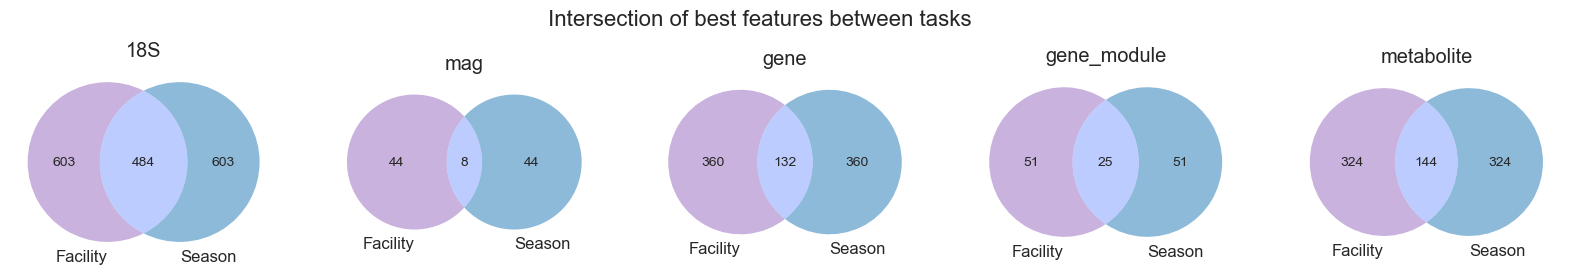

In [15]:
#plot a venn diagram per omic
fig, axn = plt.subplots(1, 5, figsize=(20, 5))
for ax_, omic_id in zip(axn.flatten(), tables.keys()):
    
    facility_feats = feats_per_omic_split[omic_id]['facility']
    season_feats = feats_per_omic_split[omic_id]['season']
    common_feats = set(facility_feats).intersection(set(season_feats))

    a = len(facility_feats) - len(common_feats)
    b = len(common_feats)
    c = len(season_feats) - len(common_feats)

    venn2(subsets=(a, c, b), set_labels=('Facility', 'Season'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of best features between tasks'.format(task), 
                 fontsize=16, y=0.8)
#plt.tight_layout()
plt.show()

In [16]:
top_feats_per_omic = {} #contains top features only

#iterate through all omics
for omic in tables.keys():
    
    feats_per_task_lst = []
    #iterate through top+bottom features in 
    # facility and season classification
    for task in best_pc_per_task_kw.keys():
        #get best PC based on Joint-RPCA KW results
        best_pc = best_pc_per_task_kw[task]
        #get top and bottom features
        top_fts = joint_top_fts_all[best_pc][omic]
        #combine all features from facility and season
        feats_per_task_lst.extend(top_fts)
    
    #remove duplicates (if any) from combined list
    feats_per_task_lst = list(set(feats_per_task_lst))
    print("{}: {} features".format(omic, len(feats_per_task_lst)))
    #store all features per omic
    top_feats_per_omic[omic] = feats_per_task_lst

18S: 905 features
mag: 47 features
gene: 448 features
gene_module: 70 features
metabolite: 460 features


In [17]:
#save as json file
with open("../results/joint-rpca/rf_top_feats_to_remove.json", "w") as outfile: 
    json.dump(top_feats_per_omic, outfile)

### Detailed F1-scores

In [ ]:
#get best PC per omic
task = 'stage' #'season', 'facility'
#groups = ['fall', 'spring', 'summer', 'winter'] #for season
#groups = ['FIRS', 'STAFS', 'ARF'] #for facility
groups = ['active', 'advanced', 'initial', 'early'] #for stage

best_pc = best_pc_acc[task]
rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                             'Report', 'Optimization', 'PC'])
for omic in best_pc.keys():
    pc_to_use = best_pc[omic][0]
    #filter out the other PCs
    mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
    rf_pc_ratio_task = pc_ratio[task][mask]
    #append to new df
    rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

display(rf_pc_ratio_plotting.head())

In [ ]:
omic_f1_lst = []
for omic in rf_pc_ratio_plotting.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = rf_pc_ratio_plotting[(rf_pc_ratio_plotting.Omic == omic) & 
                                           (rf_pc_ratio_plotting.Fold == fold)].Report.values[0]
        #get each group's F1-score
        group_f1_lst = []
        for g, i in zip(groups, range(2, 6)):
            group_report = fold_report.split('\n')[i].split(' ')
            group_result = [x for x in group_report if len(x)>0][1:]
            group_f1 = [float(x) for x in group_result][2]
            group_f1_lst.append(group_f1)
        fold_f1_lst.extend(group_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [ ]:
#create new dataframe with f1 results
omic_lst = [[omic] * 10 * len(groups) for omic in rf_pc_ratio_plotting.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * len(groups) for i in range(10)] * 10
fold = np.concatenate(fold)
group_lst = groups * 100

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 
                      'Group': group_lst, 'F1-score': omic_f1_lst})
f1_df.head()

In [ ]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
plotting_params = {'x':'Group', 'y':'F1-score', 
                   'palette':pair_palette, 'hue_order':order_v1,
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('{} {} (Detailed)'.format(ml_name, task.title()))
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Decomposer Network

In [ ]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_4PCs.csv'.format(pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [ ]:
#create dict with best PC per omic, based on KW results
best_pc_per_task_kw = {'stage_minus_facility': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC2',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC4',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC4'},
                        'stage_minus_season': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC4',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC3',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC2'},
                        'stage_minus_both': {'18S_Joint-RPCA': 'PC2',
                                             '18S_RPCA': 'PC4',
                                             'Gene_Joint-RPCA': 'PC2',
                                             'Gene_RPCA': 'PC2',
                                             'Gene_Module_Joint-RPCA': 'PC2',
                                             'Gene_Module_RPCA': 'PC2',
                                             'MAG_Joint-RPCA': 'PC2',
                                             'MAG_RPCA': 'PC3',
                                             'Metabolite_Joint-RPCA': 'PC2',
                                             'Metabolite_RPCA': 'PC2'}}

In [ ]:
acc_task = {}

for diff in best_pc_per_task_kw.keys():
    
    acc_omic = {}
    for omic in best_pc_per_task_kw[diff].keys():
        pc_to_use = best_pc_per_task_kw[diff][omic]

        #keep relevant PCs for each classification task
        mask = (pc_ratio['facility']['Omic'] == omic) & (pc_ratio['facility']['PC'] == pc_to_use)
        pc_ratio_facility = pc_ratio['facility'][mask]

        mask = (pc_ratio['stage']['Omic'] == omic) & (pc_ratio['stage']['PC'] == pc_to_use)
        pc_ratio_stage = pc_ratio['stage'][mask]

        mask = (pc_ratio['season']['Omic'] == omic) & (pc_ratio['season']['PC'] == pc_to_use)
        pc_ratio_season = pc_ratio['season'][mask]

        #calculate differences in accuracy for each fold
        acc_fold = []
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            stage_acc = pc_ratio_stage[pc_ratio_stage.Fold == fold].Accuracy.values[0]
            
            if diff == 'stage_minus_facility':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - facility_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_season':
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - season_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_both':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - (facility_acc + season_acc)
                #diff_ = stage_acc - (facility_acc + season_acc)/2
                acc_fold.append(diff_)

        acc_omic[omic] = acc_fold
    acc_task[diff] = acc_omic

In [ ]:
diff_df = pd.DataFrame(columns=['Omic', 'Fold', 'Difference', 'Task'])
for task, omic_dict in acc_task.items():
    for omic, values in omic_dict.items():
        for fold, value in zip(['traintest_{}'.format(i) for i in range(10)], values):
            diff_df = diff_df._append({'Omic': omic, 'Fold': fold, 
                                       'Difference': value, 'Task': task}, ignore_index=True)
#sanity check  
display(diff_df)

In [ ]:
#barplot of differences
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
groups = diff_df.Task.unique()
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
plotting_params = {'x':'Task', 'y':'Difference', 
                   'data':diff_df, 'palette':pair_palette,
                   'hue':'Omic', 'hue_order':order_v1,
                   'order': groups}

plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#update x labels
current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
updated_labels = ['Stage - Facility', 'Stage - Season', 
                  'Stage - (Facility + Season)']
ax_.set_xticklabels(updated_labels)
#x axis rotation
ax_.set_xlabel('')
ax_.set_ylabel('Difference in Accuracy')
ax_.set_title('RF Differences in Accuracy (KW PCs)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
##keep only stage_minus_both
diff_df_sub = diff_df[diff_df.Task == 'stage_minus_both'].copy()
#Create separate columns for Omic and Method
diff_df_sub['Omic_Only'] = [omic.split('_')[0] if 'Module' not in omic else '_'.join(omic.split('_')[0:2]) for omic in diff_df_sub.Omic]
diff_df_sub['Method'] = ["Joint-RPCA" if "Joint" in omic else "RPCA" for omic in diff_df_sub.Omic]

In [ ]:
#barplot of differences
omic_types = diff_df_sub.Omic_Only.unique()
pair_palette = {'RPCA': 'lightsteelblue', 'Joint-RPCA': 'tab:purple'}
stat_pairs = [[(omic, "RPCA"), (omic, "Joint-RPCA")] for omic in omic_types]
plotting_params = {'x':'Omic_Only', 'y':'Difference', 
                   'data':diff_df_sub, 'palette':pair_palette,
                   'hue':'Method', 
                   'order': ['18S', 'MAG', 'Gene', 'Gene_Module', 'Metabolite'],
                   'hue_order':['RPCA', 'Joint-RPCA']}

plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xlabel('')
#ax_.set_ylabel('Stage - (Facility + Season)')
ax_.set_ylabel('Stage - (Facility + Season)/2')
ax_.set_title('RF Differences in Accuracy (KW PCs)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
best_pc_stage_kw = 'PC2'
pc_to_use = best_pc_stage_kw

pc_ratio_stage = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                       'Report', 'Optimization', 'PC'])
#keep relevant PCs for each classification task
for omic in ['Metabolite_RPCA', 'Metabolite_Joint-RPCA']:
    mask = (pc_ratio['stage']['Omic'] == omic) & (pc_ratio['stage']['PC'] == pc_to_use)
    pc_ratio_sub = pc_ratio['stage'][mask]
    pc_ratio_stage = pc_ratio_stage._append(pc_ratio_sub, ignore_index=True)

In [ ]:
groups = ['active', 'advanced', 'early', 'initial']
n_groups = len(groups)
omic_precision = {}
omic_recall = {}
omic_f1 = {}

for omic in pc_ratio_stage.Omic.unique():
    fold_precision_lst = []
    fold_recall_lst = []
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = pc_ratio_stage[(pc_ratio_stage.Omic == omic) & 
                                     (pc_ratio_stage.Fold == fold)].Report.values[0]
        #store precision and recall scores for all groups
        group_precision_lst = []
        group_recall_lst = []
        group_f1_lst = []
        #we start at 2 to skip the title and a line skip
        for i in range(2, n_groups+2):
            #get group-specific results
            group_report = fold_report.split('\n')[i].split(' ')
            #keep only non-empty strings
            group_result = [x for x in group_report if len(x)>0][1:]
            group_precision = [float(x) for x in group_result][0]
            group_recall = [float(x) for x in group_result][1]
            group_f1 = [float(x) for x in group_result][2]
            #append to fold list
            group_precision_lst.append(group_precision)
            group_recall_lst.append(group_recall)
            group_f1_lst.append(group_f1)
        
        #calculate fold average
        fold_precision_lst.append(np.mean(group_precision_lst))
        fold_recall_lst.append(np.mean(group_recall_lst))
        fold_f1_lst.append(np.mean(group_f1_lst))

    #save results at the omic level
    omic_precision[omic] = fold_precision_lst
    omic_recall[omic] = fold_recall_lst
    omic_f1[omic] = group_f1_lst

In [ ]:
#create new dataframe avg precision and recall results
omic_lst = [[omic] * 10 for omic in pc_ratio_stage.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] for i in range(10)] * 2
fold = np.concatenate(fold)
precisions = np.concatenate([omic_precision[omic] for omic in pc_ratio_stage.Omic.unique()])
recalls = np.concatenate([omic_recall[omic] for omic in pc_ratio_stage.Omic.unique()])
f1s = np.concatenate([omic_f1[omic] for omic in pc_ratio_stage.Omic.unique()])

precision_recall_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold,
                                    'Avg_Precision': precisions,
                                    'Avg_Recall': recalls})

In [ ]:
#boxplot of precision and recall
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, x='Omic', y='value', hue='variable',
            data=pd.melt(precision_recall_df, ['Omic', 'Fold']),
            palette='tab10')

In [ ]:
#plot precision and recall curve for each omic on same plot
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.lineplot(data=precision_recall_df[precision_recall_df.Omic == 'Metabolite_RPCA'], 
             x='Avg_Recall', y='Avg_Precision')
ax_.set_xlabel('Average Recall')
ax_.set_ylabel('Average Precision')
ax_.set_title('PR Curve for Metabolite Stage of Decomp. Classification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

In [ ]:
#plot precision and recall curve for each omic on same plot
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.lineplot(data=precision_recall_df[precision_recall_df.Omic == 'Metabolite_Joint-RPCA'], 
             x='Avg_Recall', y='Avg_Precision')
ax_.set_xlabel('Average Recall')
ax_.set_ylabel('Average Precision')
ax_.set_title('PR Curve for Metabolite Stage of Decomp. Classification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()